# Air Quality and Social Justice

In the Salt Lake area, where smog will periodically hide the mountains that surround the city, [air pollution](http://slcair.communication.utah.edu/) is a consistent concern. The smog is a result of the pollution trapped by the unique topographic features of the Wasatch area. In this notebook, we will explore the relationship between air quality (pm25 and ozone) and income and elevation in the Salt Lake valley. This will allow us to explore questions related to social justice such as, "Is air pollution exposure equally distributed across different socio-economic groups?"

#### Tell our plotting routines to draw the graphics in our web browser

In [3]:
%matplotlib inline

### Import packages that we are going to use
#### These include

* [Pandas](http://pandas.pydata.org/index.html): A package for reading and manipulating tabular data.
* [Seaborn](https://seaborn.pydata.org/index.html): Seaborn is a plotting package that provides "nice" pre-defined plots for a variety of common graph types.
* [Folium](http://python-visualization.github.io/folium/docs-v0.5.0/): Folium is a good package for visualizing data on a map.
* [statsmodels](http://www.statsmodels.org/stable/): This package provides a number of common statistical functions for analysing data.


In [4]:
import pandas as pd
import statsmodels
import statsmodels.formula.api as smf
import patsy
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from ipywidgets import widgets

#### Tell our program where our data are located

In [ ]:
DATADIR = "/home/jovyan/DATA/AirQuality"

In [ ]:
os.listdir(DATADIR)

### What are these data

In our data directory we have two **csv** files (csv stands for **C**omma **S**eparated **V**alues). For different regions in the Salt Lake valley (zip code), we have computed the average

1. Income
1. Elevation
1. pm25 levels for March 8, 2016
1. ozone levels at 10:00 am and 3:00 PM from August 2016.

These files have been created by Dr. Daniel L. Mendoza at the University of Utah.

## Use Pandas to read in the data

Pandas reads the data into a Pandas **dataframe** which we assing to the variable ``pm25``. Dataframes have two methods for looking at the data ``head()`` and ``tail()``

In [ ]:
#original
pm25 = pd.read_csv(os.path.join(DATADIR, "Class_PM25_Data.csv"))
pm25.head(), pm25.tail()

In [5]:
pm25 = pd.read_csv("Class_PM25_Data.csv")
pm25.tail()

,Block_Group_ID,Income,Elevation,PM25_MAR_8
60,4.903510e+11,69188.0,1321.630859,4.409883
61,4.903510e+11,69493.0,1312.114014,3.989309
62,4.903510e+11,92551.0,1557.853394,1.537066
63,4.903510e+11,60817.0,1552.666016,2.252555
64,4.903600e+11,NaN,1275.227905,3.717521


#### Notice the ``NaN`` value for Income in our last data row

Pandas uses ``NaN`` (Not a number) to represent missing values. That is our data file did not have an income value for the last row. There are a variety of approaches for dealing with missing data, but we are just going to drop that value using the Pandas dataframe ``dropna`` method.



In [6]:
pm25 = pm25.dropna()
pm25.tail()

,Block_Group_ID,Income,Elevation,PM25_MAR_8
59,4.903510e+11,35375.0,1305.029541,3.595146
60,4.903510e+11,69188.0,1321.630859,4.409883
61,4.903510e+11,69493.0,1312.114014,3.989309
62,4.903510e+11,92551.0,1557.853394,1.537066
63,4.903510e+11,60817.0,1552.666016,2.252555


### Now let's repeat this with the ozone data

In [ ]:
#original
ozone = pd.read_csv(os.path.join(DATADIR, "Class_Ozone_Data.csv"))
ozone.tail()

In [7]:
ozone = pd.read_csv("Class_Ozone_Data.csv")
ozone = ozone.dropna()
ozone.tail()

,Block_Group_ID,Income,Elevation,Ozone_AUG_10,Ozone_AUG_15
59,490351140001,35375.0,1305.029541,22.561118,48.027862
60,490351142001,69188.0,1321.630859,30.320732,57.617152
61,490351142002,69493.0,1312.114014,31.675820,59.208955
62,490351152091,92551.0,1557.853394,36.326890,58.199097
63,490351152092,60817.0,1552.666016,36.182543,57.752619


## Exploratory Plots

In statistics, it is always a good idea to start by plotting your data to get an idea of what it looks like. This can help you determine which analyses would be useful to perform. Here we are going to be using [Seaborn](http://seaborn.pydata.org/index.html) to do some exploratory visualization.

Our first plot is going to be a [histogram](https://en.wikipedia.org/wiki/Histogram) of our particle measurements.

Seaborn has several options for plotting histograms. We are going to use the ``distplot()`` function. Note that we set the [kernal density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) argument (a smoothing function) to True. What happens when you change it to False?

Text(0.5,1,'Histogram of PM25 for March 8, 2016')

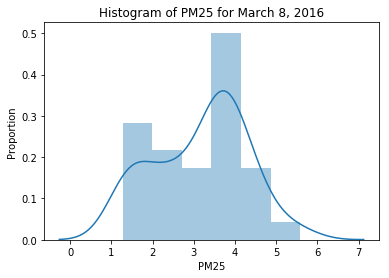

In [13]:
fig1, ax1 = plt.subplots(1)
sns.distplot(pm25["PM25_MAR_8"], ax=ax1, kde=True)
ax1.set_xlabel("PM25")
ax1.set_ylabel("Proportion")
ax1.set_title("Histogram of PM25 for March 8, 2016")

Next we'll use ``jointplot`` to visualize the relationship between income and pollution levels. ``jointplot`` has a number of options that determine what kind of joint plot to generate. The default is "scatter", but here we'll use the [regression](https://en.wikipedia.org/wiki/Linear_regression) fit. Notice we also added kde to the marginal histograms with the regression fit. Any of the following types can be plotted using ``jointplot`` by changing the 'kind' argument:

* "scatter"
* "reg"
* "resid"
* "kde"
* "hex"

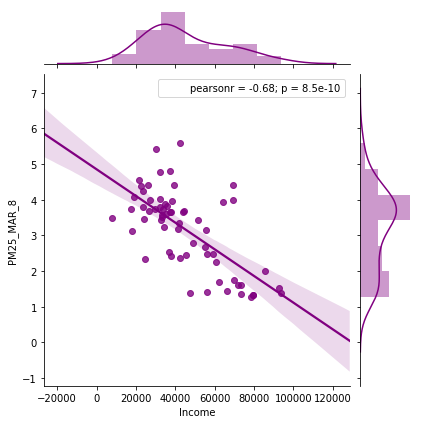

In [11]:
sns.jointplot(x="Income", y="PM25_MAR_8", data=pm25, kind="reg",
             color='purple');

### We can see that there is a reasonable linear relationship between pollution and income


#### Let's quantify this relationship

We will use ``statsmodels`` to do [ordinary least squares regression](https://en.wikipedia.org/wiki/Ordinary_least_squares).

```Python
mod = smf.ols(formula='PM25_MAR_8 ~ Income', data=pm25)
```

* Use Patsy to specify what our regression is. This formula is stating a linear relationship between our dependent variable, ``PM25_MAR_8``, and our independent variable, ``Income``.

```Python
'PM25_MAR_8 ~ Income'
```
```Python
data=pm25
```

* Use the ``pm25`` dataset
* ``mod.fit()`` fits the model to the data
* ```res.summary()``` provides a detailed report on how well the model fit the data.

In [14]:
mod = smf.ols(formula='PM25_MAR_8 ~ Income', data=pm25)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PM25_MAR_8   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     52.32
Date:                Sun, 13 May 2018   Prob (F-statistic):           8.48e-10
Time:                        14:17:09   Log-Likelihood:                -77.678
No. Observations:                  64   AIC:                             159.4
Df Residuals:                      62   BIC:                             163.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8552      0.256     18.981      0.000       4.344       5.367
Income      -3.74e-05   5.17e-06     -7.233      0.000   -4.77e-05   -2.71e-05
==============================================================================
Omnibus:                        6.338   Durbin-Watson:                   1.194
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.446
Skew:                           0.624   Prob(JB):                       0.0657
Kurtosis:                       3.697   Cond. No.                     1.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### This is a lot of information. What are the key points?

#### Let's start by looking at our overall model.

* **Prob (F-statistic):**           8.48e-10 ($8.48e^{-10}$). 
    * This is the probability that the linear relationship between our variables is purely due to chance. 
* **R-squared:**                       0.458
    * This is the proportion of the variability in our data that is explained by our model, so about half of the variability in the data is explained by income.
* **Cond. No.**                     1.22e+05 ($1.22e^{05}$)
    * A large condition number indicates numeric problems with our model/data and mean the results are less reliable.

#### Now let's look at our ``Income`` variable

* **coef**=-3.74e-05 ($-3.74e^{-05}$). This is the slope of the line. The slope is negative, meaning as income **increases**, air pollution **decreases.**
* **P**=0.000. This is the "p-value" and describes the probability that the linear relationship is just random chance. Since our p-value is less than 0.001, we can accept our hypothesis that income and pollution are related.

## Let's repeat this for the relationship between ``Income`` and ``Elevation``

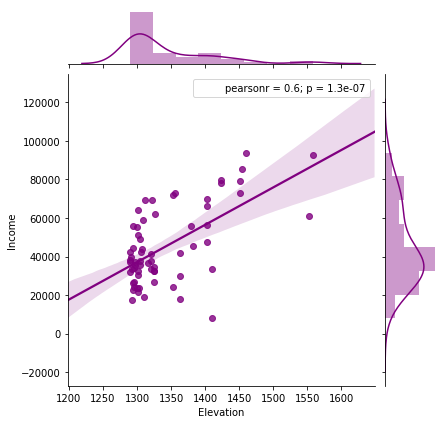

In [15]:
sns.jointplot(y="Income", x="Elevation", data=pm25, kind="reg",
             color='purple');

### The relationship between ``Income`` and ``Elevation`` is strong
### Now let us use ``Elevation`` to predict ``PM25_MAR_8``

In [16]:
mod = smf.ols(formula='PM25_MAR_8 ~ Elevation', data=pm25)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PM25_MAR_8   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     50.84
Date:                Sun, 13 May 2018   Prob (F-statistic):           1.28e-09
Time:                        14:18:24   Log-Likelihood:                -78.095
No. Observations:                  64   AIC:                             160.2
Df Residuals:                      62   BIC:                             164.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1668      2.247      8.531      0.000      14.675      23.658
Elevation     -0.0119      0.002     -7.130      0.000      -0.015      -0.009
==============================================================================
Omnibus:                        1.175   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                0.988
Skew:                           0.013   Prob(JB):                        0.610
Kurtosis:                       2.392   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Can we build a model that uses *both* ``Elevation`` and ``Income`` to predict pollution levels?

In [19]:
mod = smf.ols(formula='PM25_MAR_8 ~ Elevation + Income + Elevation:Income', data=pm25)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PM25_MAR_8   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     27.61
Date:                Sun, 13 May 2018   Prob (F-statistic):           2.42e-11
Time:                        14:29:07   Log-Likelihood:                -69.505
No. Observations:                  64   AIC:                             147.0
Df Residuals:                      60   BIC:                             155.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           22.4080      6.418      3.492      0.001       9.571      35.245
Elevation           -0.0135      0.005     -2.811      0.007      -0.023      -0.004
Income              -0.0002      0.000     -1.624      0.110      -0.000    3.82e-05
Elevation:Income  1.034e-07   7.42e-08      1.393      0.169    -4.5e-08    2.52e-07
==============================================================================
Omnibus:                        3.191   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.305
Skew:                           0.386   Prob(JB):                        0.316
Kurtosis:                       3.517   Cond. No.                     4.74e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### What happens when we include both predictors?

# Now let's look at ozone

[Ozone](https://www.epa.gov/ozone-pollution) is another cause for concern in air quality. It is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC) in the presence of sunlight. Emissions from industrial facilities and electric utilities, motor vehicle exhaust, gasoline vapors, and chemical solvents are some of the major sources of NOx and VOC. Ground level ozone can cause breathing problems in sensitive populations and can also be harmful to delicate ecosystems.

## We have ozone measurements at two times: 10:00 AM and 3:00 PM (15:00)

#### How are these measurements different? Let's use ``distplot()`` to visualize the histograms side-by-side.
#### What do you think might account for differences between the two time points?

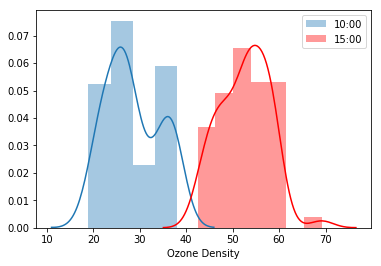

In [20]:
fig2, ax2 = plt.subplots(1)
sns.distplot(ozone["Ozone_AUG_10"], ax=ax2, label="10:00")
sns.distplot(ozone["Ozone_AUG_15"], ax=ax2, color='r', label="15:00")
ax2.set_xlabel("Ozone Density")
ax2.legend()

## Ozone vs pm25

#### Use the same plotting and statistical functions we used above to explore the relationship between ozone and income and elevation

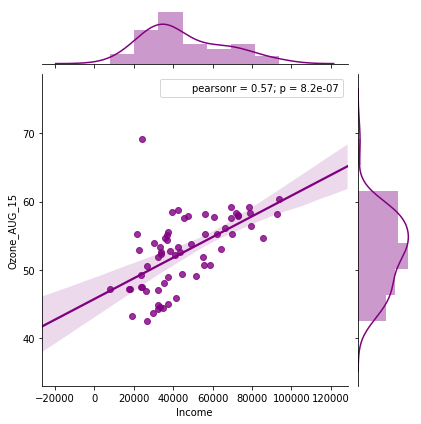

In [21]:
sns.jointplot(x="Income", y="Ozone_AUG_15", data=ozone, kind="reg",
             color='purple');

Here it looks like we have the opposite relationship between income and ozone. As income **increases**, ozone exposure **increases**. Why might this be? (Click one of the options.)

In [17]:
button1 = widgets.Button(description='a. Ozone levels decrease with elevation',layout=widgets.Layout(width='40%', height='40px'))
button2 = widgets.Button(description='b. Wealthy people spend more time outdoors',layout=widgets.Layout(width='40%', height='40px'))
button3 = widgets.Button(description='c. Ozone levels increase with elevation, as does income',layout=widgets.Layout(width='40%', height='40px'))
button4 = widgets.Button(description='d. Too much noise; relationship is not obvious',layout=widgets.Layout(width='40%', height='40px'))
display(button1,button2,button3, button4)

def on_correct_clicked(b):
    print('Correct.')
def on_incorrect_clicked(b):
    print('Not quite.')
    
button1.on_click(on_incorrect_clicked)
button2.on_click(on_incorrect_clicked)
button3.on_click(on_correct_clicked)
button4.on_click(on_incorrect_clicked)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Please try again.
Correct.


In [22]:
mod = smf.ols(formula='Ozone_AUG_15 ~ Elevation', data=ozone)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Ozone_AUG_15   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     8.786
Date:                Sun, 13 May 2018   Prob (F-statistic):            0.00430
Time:                        14:38:35   Log-Likelihood:                -193.18
No. Observations:                  64   AIC:                             390.4
Df Residuals:                      62   BIC:                             394.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3968     13.569      0.914      0.364     -14.728      39.521
Elevation      0.0299      0.010      2.964      0.004       0.010       0.050
==============================================================================
Omnibus:                        5.342   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.559
Skew:                           0.343   Prob(JB):                       0.0621
Kurtosis:                       4.271   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
mod = smf.ols(formula='Ozone_AUG_15 ~ Income', data=ozone)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Ozone_AUG_15   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     30.06
Date:                Sun, 13 May 2018   Prob (F-statistic):           8.16e-07
Time:                        14:38:35   Log-Likelihood:                -184.78
No. Observations:                  64   AIC:                             373.6
Df Residuals:                      62   BIC:                             377.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.7387      1.363     33.548      0.000      43.013      48.464
Income         0.0002   2.76e-05      5.483      0.000     9.6e-05       0.000
==============================================================================
Omnibus:                       27.944   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.778
Skew:                           1.245   Prob(JB):                     1.29e-17
Kurtosis:                       7.792   Cond. No.                     1.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""